We depend on this sync_lib library that is one folder above

In [63]:
import sys
!pip install tabulate
sys.path.append('../')

You should consider upgrading via the '/Users/jeromel/anaconda2/envs/deep_work/bin/python -m pip install --upgrade pip' command.


In [12]:
from sync_lib import Dataset
import matplotlib.pylab as plt
import numpy as np
import glob
import pandas as pd

Path to relevant sync file

In [7]:
list_h5_files = glob.glob("*/*.h5")

In [8]:
list_h5_files

['det_change_long_no_licks/2021T143928.h5',
 'detection_of_change_with_camera/2021T15144.h5',
 'det_change_short_manual/2021T17922.h5',
 'GridGratingDrawing/2021T134531.h5',
 'keyboard_test_1/go_no_go_hardware_2021T155621.h5',
 'detection_of_change_without_camera/2021T151449.h5',
 'det_change_long_fake_lick_generator/2021T133340.h5',
 'PassiveViewing_run1/2021T135255.h5',
 'long_stim_test_1/go_no_go_hardware_2021T12950.h5']

In [64]:
rendering_mean = []
rendering_std = []
photodiode_driving_mean = []
photodiode_driving_std = []
photodiode_response_mean = []
photodiode_response_std = []
photodiode_dropped = []

index = []
for indiv_path in list_h5_files:
    local_folder = indiv_path.split('/')[0]
    dset = Dataset(indiv_path)
    if not('GridGratingDrawing' in local_folder):
        if 'detection_of_change_with_camera' in local_folder:
            local_folder = 'det_change_with_camera'
        if 'detection_of_change_without_camera' in local_folder:
            local_folder = 'det_change_without_camera'
        if 'PassiveViewing_run1' in local_folder:
            local_folder = 'passive_viewing_long'
        if 'long_stim_test_1' in local_folder:
            local_folder = 'go_no_go_' + local_folder 
        if 'keyboard_test_1' in local_folder:
            local_folder = 'go_no_go_' + local_folder 

        index.append(local_folder)

        # This is the stim rendering period
        times_bonsai_fast_sync = dset.get_rising_edges('vsync_stim', units='sec')
        rendering_mean.append(np.mean(np.diff(times_bonsai_fast_sync[10:-10])))
        rendering_std.append(np.std(np.diff(times_bonsai_fast_sync[10:-10])))

        # This is the driving signal behind the photodiode
        times_bonsai_driving_photodiode = dset.get_rising_edges(
            'stim_running', units='sec')
        photodiode_driving_mean.append(np.mean(np.diff(times_bonsai_driving_photodiode[10:-10])))
        photodiode_driving_std.append(np.std(np.diff(times_bonsai_driving_photodiode[10:-10])))

        # This is the measured photodiode signal
        times_photodiode = dset.get_rising_edges('stim_photodiode', units='sec')
        photodiode_response_mean.append(np.mean(np.diff(times_photodiode[10:-10])))
        
        period_photodiode = np.diff(times_photodiode[10:-10])

        photodiode_response_std.append(np.std(period_photodiode))
        
        delta_photodiode = np.abs(np.diff(period_photodiode)-np.mean(np.diff(period_photodiode)))
        photodiode_dropped.append(len(delta_photodiode[delta_photodiode>0.033]))

all_dict = {'Bonsai rendering period mean':rendering_mean, 'Bonsai rendering std': rendering_std, 'Photodiode driving period mean': photodiode_driving_mean, 'Photodiode driving period std':photodiode_driving_std, 'Photodiode actual period mean':photodiode_response_mean, 'Photodiode actual period std':photodiode_response_std, 'Photodiode dropped frames':photodiode_dropped}
df = pd.DataFrame(all_dict, columns = ['Bonsai rendering period mean'
    ,'Bonsai rendering std', 'Photodiode driving period mean', 'Photodiode driving period std', 'Photodiode actual period mean', 'Photodiode actual period std', 'Photodiode dropped frames'], index = index)

from pandas import DataFrame
from tabulate import tabulate

print(tabulate(df, tablefmt="pipe", headers="keys"))


|                                     |   Bonsai rendering period mean |   Bonsai rendering std |   Photodiode driving period mean |   Photodiode driving period std |   Photodiode actual period mean |   Photodiode actual period std |   Photodiode dropped frames |
|:------------------------------------|-------------------------------:|-----------------------:|---------------------------------:|--------------------------------:|--------------------------------:|-------------------------------:|----------------------------:|
| det_change_long_no_licks            |                      0.0333329 |            0.000253716 |                         0.999986 |                     0.000158512 |                        0.999986 |                    1.67488e-05 |                           0 |
| det_change_with_camera              |                      0.0333386 |            0.000942805 |                         0.999984 |                     6.55527e-05 |                        0.999984 |        

Here we plot the period of stimulus rendering, driving photo-diode and photo-diode response time after screen flipping

ipykernel_launcher:36: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.


(0.9999499999998989, 1.0000200000004043)

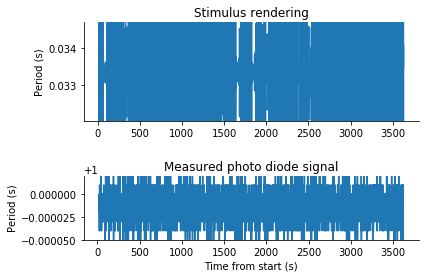

In [58]:

# This is the fastest output from bonsai to digital line
times_bonsai_fast_sync = dset.get_rising_edges('vsync_stim', units='sec')

# This is the driving signal behind the photodiode
times_bonsai_driving_photodiode = dset.get_rising_edges(
    'stim_running', units='sec')

times_photodiode = dset.get_rising_edges('stim_photodiode', units='sec')

plt.subplot(2, 1, 1)
y_axis_data = np.diff(times_bonsai_fast_sync)
plt.plot(times_bonsai_fast_sync[1:], y_axis_data)
plt.ylabel('Period (s)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.title('Stimulus rendering')
plt.ylim([np.percentile(y_axis_data,0.5),np.percentile(y_axis_data,99.5)])

plt.subplot(2, 1, 2)
plt.plot(times_bonsai_driving_photodiode[1:], np.diff(
    times_bonsai_driving_photodiode))
plt.ylabel('Period (s)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.title('Driving photo diode signal')

plt.subplot(3, 1, 3)
y_axis_data = np.diff(
    times_photodiode)
plt.plot(times_photodiode[1:], y_axis_data)
plt.xlabel('Time from start (s)')
plt.ylabel('Period (s)')
plt.title('Measured photo diode signal')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('go_no_go_hardware_2021T12950_sync_lines.png')
plt.ylim([np.percentile(y_axis_data,1),np.percentile(y_axis_data,99)])



This is to dive further into photodiode signal and visualize the stability of the photodiode period after flipping

"\nplt.subplot(3, 1, 3)\nplt.plot(times_response[:-1], times_response[:-1]-times_command[:-3])\n\nplt.ylabel('Delay (s)')\nplt.xlabel('Session time (seconds)')\nplt.title('From Photodiode command to flip')\nplt.gca().spines['right'].set_visible(False)\nplt.gca().spines['top'].set_visible(False)\nplt.tight_layout()\n"

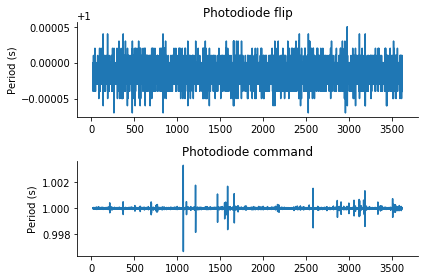

In [59]:

times_command = dset.get_rising_edges('stim_running', units='sec')
times_response = dset.get_rising_edges('stim_photodiode', units='sec')

plt.subplot(2, 1, 1)
plt.plot(times_response[:-2], np.diff(times_response[:-1]))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.ylabel('Period (s)')
plt.title('Photodiode flip')

plt.subplot(2, 1, 2)
plt.plot(times_response[:-2], np.diff(times_command[:-3]))
plt.ylabel('Period (s)')
plt.title('Photodiode command')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig("det_change_simulated_manual_licks.png")

"""
plt.subplot(3, 1, 3)
plt.plot(times_response[:-1], times_response[:-1]-times_command[:-3])

plt.ylabel('Delay (s)')
plt.xlabel('Session time (seconds)')
plt.title('From Photodiode command to flip')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tight_layout()
"""

Here we plot the *turn-around time* or the time it takes to immediately turn around a lick, ie. read a lick from sync on the arduino and convert to a digital line through DAQmx+NI card via Bonsai


Text(0, 0.5, 'Number of licks')

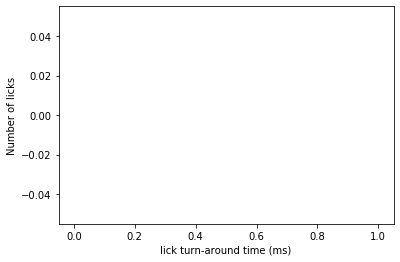

In [60]:
bit_trace = dset.get_bit_rising_edges(15, units='sec')
times_sync_licks = dset.get_rising_edges('lick_sensor', units='sec')[1:]
plt.hist(1000*(bit_trace[1:]-times_sync_licks))
plt.xlabel('lick turn-around time (ms)')
plt.ylabel('Number of licks')

Here we plot the time it takes to convert a lick into a reward. 
* *Calculation + digital line delay* is the time from Sync knowing a lick occured to the time sync received a reward from Bonsai. This time contains both the calculation reaction time as well as the time for Bonsai to read and write digital lines. 
* *Corrected calculation delay* is the same duration minus the local delay for Bonsai to turn around a pure lick. This represents the expected time it took bonsai to convert a lick into a reward. 

In [61]:
change_flash_times = dset.get_bit_rising_edges(6, units='sec')
reward_times = dset.get_bit_rising_edges(3, units='sec')
lick_in_out = dset.get_bit_rising_edges(15, units='sec')
lick_in = dset.get_rising_edges('lick_sensor', units='sec')[1:]

plt.subplot(2,1,1)
list_delta_reward = []
for indiv_time in reward_times:
    all_delta_times = indiv_time-lick_in
    all_delta_times = all_delta_times[all_delta_times>0]
    local_time = np.min(all_delta_times)*1000

    list_delta_reward.append(local_time)
plt.hist(list_delta_reward)
plt.xlabel('Calculation + digital line delay (ms)')
plt.ylabel('Reward #')

plt.subplot(2,1,2)
list_delta_reward = []
for indiv_time in reward_times:
    all_delta_times = indiv_time-lick_in_out
    all_delta_times = all_delta_times[all_delta_times>0]
    local_time = np.min(all_delta_times)*1000

    list_delta_reward.append(local_time)
plt.hist(list_delta_reward)
plt.xlabel('Corrected calculation delay (ms)')
plt.ylabel('Reward #')
plt.tight_layout()

ValueError: zero-size array to reduction operation minimum which has no identity

Changes were presented at varying intervals drawn from an uniform distribution between 3 and 5 image presentations. This looks at the stability of this. This distribution can be skewed by aborts.

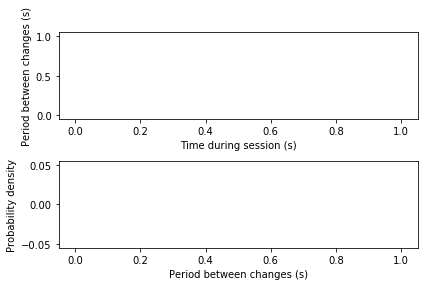

In [40]:
time_of_changes = dset.get_bit_rising_edges(6, units='sec')
plt.subplot(2,1,1)
plt.plot(time_of_changes[1:-1], np.diff(time_of_changes[:-1]))
plt.xlabel('Time during session (s)')
plt.ylabel('Period between changes (s)')
plt.subplot(2,1,2)
plt.hist(np.diff(time_of_changes))
plt.xlabel('Period between changes (s)')
plt.ylabel('Probability density')
plt.tight_layout()
